In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

import cv2
import os
import pickle
import random

from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm

from skimage.feature import hog
from skimage import exposure

from pathlib import Path

from keras.preprocessing import image
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import *
from keras.callbacks import * 

Using TensorFlow backend.


# Preprocessing Data

In [ ]:
def collecting_image(dirs):
    """
        dirs - directories in a certain path folder.
        Takes png files in each directory and returns to a rgb matrix.
        If a png file is none, remove the png file.
        os.remove() will clean all broken png files.
    """
    image_data = []
    labels = []
    for folder in sorted(dirs):
        label = str(folder).split('/')[-1]
        count = 0
        count1 = 0 
        # Taking all png files in img_path (a pokemon folder)
        for img_path in folder.glob("*.png"):
            img_path = str(img_path)
            img = cv2.imread(img_path) 
            if img is not None:
                img = cv2.resize(img,(64,64)) # Resize an image to 64 pixels by 64 pixels
                img_array = image.img_to_array(img) # Convert an image to an array
                image_data.append(img_array)
                labels.append(label)
                count += 1
            else:
                print(img_path)
                os.remove(img_path)
                print("File Removed")
                count1 += 1
    print('# of Images: {} for {}'.format(count, label)) 
    print("# of Removed Images", count1)
    
    return(image_data, labels)


In [ ]:
# p = Path("./data/pokemon/")
# dirs = p.glob("*")
# image_data, labels = collecting_image(dirs)

# Saving Pokemon Label Dictionary to pickle


In [ ]:
# labels_dict = {key: val for key, val in enumerate(sorted(set(labels)), 0)}
# pickle.dump(labels_dict, open("data/pokemon_label.p", 'wb'))
# pickle.dump(image_data, open("data/image_data.p", 'wb'))
# pickle.dump(labels, open("data/labels.p", 'wb'))

## Loading Pickles

In [2]:
labels_dict = pickle.load(open("data/pokemon_label.p", 'rb'))
image_data = pickle.load(open('data/image_data.p','rb'))
labels = pickle.load(open('data/labels.p','rb'))

In [3]:
X = np.array(image_data)
y = np.array(labels)
print(X.shape)
print(y.shape)

(42022, 64, 64, 3)
(42022,)


In [4]:
def drawImg(img,label):
    """ 
        Draw an input image with a label
    """
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

In [4]:
def pokemon_to_keys(y,labels_dict):
    """ y - list of pokemons
        labels_dict - {(0,151):'pokemon'}
        returns to corresponding key.
        
    """
    new_y = []
    for y_element in y:
        for k, v in labels_dict.items():
            if y_element == v:
                new_y.append(k)
    return(np.array(new_y))

## Normalizing Data

In [5]:
# 'float32' type data is more efficiently trained in a neural network. Also can be normalized.
X = X.astype('float32') / 255.0

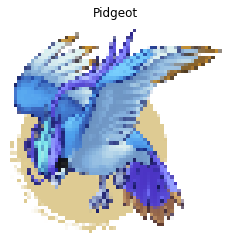

In [7]:
some_number = random.randint(a=0, b=len(X))

drawImg(X[some_number],y[some_number])


# EDA

In [13]:
from collections import Counter

pokemons, counts = zip(*Counter(y).items())
df_images = pd.DataFrame(index=pokemons, data={'# of Images':counts}) # Data Frame of the data
df_images.sort_index(inplace=True)


In [14]:
avg_num_images = df_images['# of Images'].mean()
median_num_images = df_images['# of Images'].median()

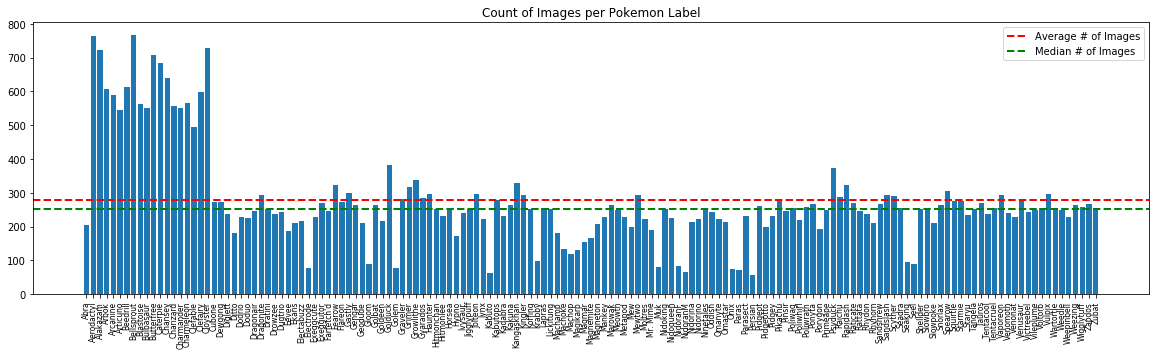

In [15]:
plt.figure(figsize=(20,5))
plt.bar(range(len(df_images)), df_images['# of Images'].values)
plt.axhline(avg_num_images, color='r', linestyle='dashed', linewidth=2, label='Average # of Images')
plt.axhline(median_num_images, color='g', linestyle='dashed', linewidth=2, label='Median # of Images')

plt.xticks(range(len(df_images)), df_images.index.values, size=7.5,rotation='vertical')
plt.legend()
plt.title('Count of Images per Pokemon Label')

plt.show()

In [70]:
def get_last_10(df_images,n):
    """ Returns to a Dataframe, which represents 'n' lowest number of images
    """
    return (df_images.sort_values(by=['# of Images'])[0:n])

Text(0, 0.5, 'Number of Images')

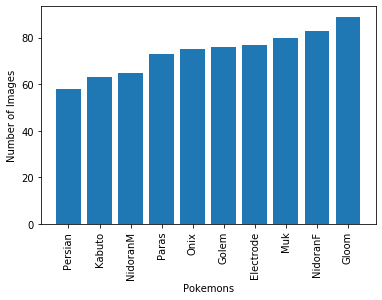

In [79]:
plt.bar(x=range(10), height=get_last_10(df_images,10)['# of Images'].values)
plt.xticks(range(10), get_last_10(df_images,10).index.values, rotation=90)
plt.xlabel('Pokemons')
plt.ylabel('Number of Images')


## Generate Some Random Pokemons

In [209]:
def random_pokemon_key(key, array):
    return int(random.choice(np.argwhere(array == key)))

In [224]:
def display_sample_pokemons(samples_indices, img_array, labels, pred_labels=None, pred_probs=None):
    n = 0
    nrows = 4
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(12,10))
    plt.subplots_adjust(wspace=0, hspace=0)
    for row in range(nrows):
        for col in range(ncols):
            index = samples_indices[n]

            ax[row,col].imshow(img_array[index])
            ax[row,col].axis('off')
            
            actual_label = labels_dict[labels[index]]
            actual_text = "Actual : {}".format(actual_label)
            
            ax[row,col].add_patch(patches.Rectangle((0, 53),64,25,color='white'))
            font0 = FontProperties()
            font = font0.copy()
            font.set_family("sans-serif")
            ax[row,col].text(1,54, actual_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')
            if (pred_labels.all() != None and pred.all() != None):
                pred_label = labels_dict[pred_labels[index]]
                pred_prob = max(pred_probs[index])*100
                pred_text = "{} : {:.0f}%".format(pred_label,pred_prob)
                ax[row,col].text(1, 59, pred_text , horizontalalignment='left', fontproperties=font,
                                 verticalalignment='top',fontsize=8, color='black',fontweight='bold')
            n += 1
            

In [6]:
# Converting Pokemon labels to corresponding keys
y = pokemon_to_keys(y, labels_dict)

In [21]:
rand_pokemon_keys = random.sample(range(0,151),20)
samples_indices = [random_pokemon_key(key, y) for key in rand_pokemon_keys]
#display_sample_pokemons(samples_indices, X, y)

# Feature Extraction
## Histogram of Oriented Gradients


<font size="4">Histogram of Oriented gradients calculates a gradient magnitude between horizontal gradient and vertical gradient of corresponding pixel's intensity value and a angle between them by arctan(grad_y/ grad_x) in each window of an image. Therefore, HOG detects edges in an image.
Check more about HOG here https://www.learnopencv.com/histogram-of-oriented-gradients/ </font>


In [30]:
def display_hog_sample_pokemons(samples_indices, img_array, labels):
    n = 0
    nrows = 4
    ncols = 5
    assert (len(samples_indices) == nrows * ncols)
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(12,10))
    plt.subplots_adjust(wspace=0, hspace=0)
    for row in range(nrows):
        for col in range(ncols):
            index = samples_indices[n]
            gray = cv2.cvtColor(img_array[index], cv2.COLOR_BGR2GRAY)
            # Compute the gradient vector or edge orientations at each pixel
            fd, hog_img = hog(gray, orientations=9, pixels_per_cell=(2, 2),
                    cells_per_block=(2, 2), visualize=True, block_norm='L1')
            
            # Rescale histogram for better display
            hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0,10))
            
            ax[row,col].imshow(hog_image_rescaled)
            ax[row,col].axis('off')
            
            actual_label = labels_dict[labels[index]]
            actual_text = "Actual : {}".format(actual_label)
            
            ax[row,col].add_patch(patches.Rectangle((0, 53),64,25,color='white'))
            font0 = FontProperties()
            font = font0.copy()
            font.set_family("sans-serif")
            ax[row,col].text(1,59, actual_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')
            n += 1
            

In [31]:
display_sample_pokemons(samples_indices, X, y)

In [32]:
display_hog_sample_pokemons(samples_indices, X, y)

TypeError: hog() got an unexpected keyword argument 'visualize'

## Examples of Pokemons

In [ ]:
squirtle_keys = np.empty(20)
squirtle_keys.fill(129)
squirtle = [random_pokemon_key(key, y) for key in squirtle_keys]

In [ ]:
pikachu_keys = np.empty(20)
pikachu_keys.fill(103)
pikachu = [random_pokemon_key(key, y) for key in pikachu_keys]

In [ ]:
display_sample_pokemons(pikachu, X, y)

In [ ]:
display_hog_sample_pokemons(pikachu, X, y)

In [ ]:
display_sample_pokemons(squirtle, X, y)

In [ ]:
display_hog_sample_pokemons(squirtle, X, y)

# Support Vector Classifier

In [24]:
# The normalization performed by scikit-image is not the one recommended by the paper. 
def extract_hog(img_array):
    """
        Extract Histogram of Oriented Gradients feature descriptions for an image.
        
    """
    winSize = (64,64)
    blockSize = (4,4)
    blockStride = (4,4)
    cellSize = (2,2)
    nbins = 9
    derivAperture = 1
    winSigma = -1
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradient = True
    
    hogD = cv2.HOGDescriptor(winSize,
                            blockSize,
                            blockStride,
                            cellSize,
                            nbins,
                            derivAperture,
                            winSigma,
                            histogramNormType,
                            L2HysThreshold,
                            gammaCorrection,
                            nlevels,
                            signedGradient
                            )
    list_fd = []
    for image in img_array:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        fd = hogD.compute(image.astype(np.uint8))
        fd = fd.T   # Convert to Transpose 
        list_fd.append(fd)
    list_fd = np.squeeze(list_fd) # Remove single-dimensional entries
    return list_fd

In [25]:
hog_fd = extract_hog(X)
hog_fd.shape # 64 x (4 x 4) x 9

(42022, 9216)

In [26]:
hog_X_train, hog_X_test, hog_y_train, hog_y_test = train_test_split(hog_fd, y, test_size=0.20)

In [143]:
# pickle.dump(hog_X_train, open("data/hog_X_train.p", 'wb'))
# pickle.dump(hog_X_test, open("data/hog_X_test.p", 'wb'))
# pickle.dump(hog_y_train, open("data/hog_y_train", 'wb'))
# pickle.dump(hog_y_test, open("data/hog_y_test.p",'wb'))

### Loading hog train and test data

In [120]:
hog_X_train = pickle.load(open("data/hog_X_train.p", 'rb'))
hog_X_test = pickle.load(open("data/hog_X_test.p", 'rb'))
hog_y_train = pickle.load(open("data/hog_y_train", 'rb'))
hog_y_test = pickle.load(open("data/hog_y_test.p",'rb'))

## Building Support Vector Classifier using OpenCV library

In [124]:
cv2_svc = cv2.ml.SVM_create()
cv2_svc.setC(2.67) # Setting Soft SVC
cv2_svc.setGamma(5.383)
cv2_svc.setKernel(cv2.ml.SVM_LINEAR)
cv2_svc.setType(cv2.ml.SVM_C_SVC)
 

In [144]:
cv2_svc.train(hog_X_train, cv2.ml.ROW_SAMPLE, hog_y_train)
cv2_svc.save('cv2_svc.dat')

In [ ]:
cv2_svc = cv2.ml.SVM_load('cv2_svc.dat')

In [145]:
pred = cv2_svc.predict(hog_X_test)

In [146]:
bias = cv2_svc.predict(hog_X_train)

In [148]:
err = (hog_y_test != pred[1].flatten()).mean()
print('Accuracy: %.2f %%' % ((1 - err)*100))

err1 = (hog_y_train != bias[1].flatten()).mean()
print("Accuracy for training: %.2f %%" % ((1 - err1) * 100))

Accuracy: 38.36 %
Accuracy for training: 81.35 %


In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    # Only use the labels that appear in the data
    classes = list(classes.values())
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(30,30))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    thresh = cm.max() / 2.
    fig.tight_layout()
    return ax


cm = confusion_matrix(hog_y_test,pred[1].flatten())
cm_norm = cm.astype('float')/ cm.sum(axis=1)
df_cm = pd.DataFrame(data=cm, index=labels_dict.values(), columns=labels_dict.values())

plot_confusion_matrix(cm,labels_dict, normalize=True)

NameError: name 'hog_y_test' is not defined

In [150]:
report = classification_report(hog_y_test,pred[1].flatten(),target_names=list(labels_dict.values()),output_dict = True)
classification_report_df = pd.DataFrame(report).T
classification_report_df = classification_report_df[0:151]

In [151]:
classification_report_df.describe()

,f1-score,precision,recall,support
count,151.000000,151.000000,151.000000,151.000000
mean,0.355109,0.522958,0.310949,55.662252
std,0.198103,0.276910,0.181320,29.817643
min,0.000000,0.000000,0.000000,10.000000
25%,0.231327,0.299601,0.203893,40.500000
50%,0.333333,0.575000,0.272727,51.000000
75%,0.425833,0.736232,0.368993,59.000000
max,0.876106,0.954023,0.930380,159.000000


# Deep Learning (CNN)
    What we want the computer to do is to differentiate between all the images and figure out each unique features from pokmeons. When we see Pikachu, we recognize its color is yellow, its cheek is red and its tail is brown. The computer will figure out each edges and curves and pass through neural network similar to visual cortex. As a result, we want the Neural Network to understand high level features of an image.
    
## Data Augmentation

    Data Augmemntation changes an input image in variety ways such as flipping horizontally/vertically or changing brightness of image, so that I can prevent overffiting from a model.
    Furthermore, the goal when applying data augmentation is to increase the generalizability of the model

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [8]:
data_aug = image.ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    featurewise_std_normalization=False, # divide input by std
    rotation_range=20, # randomly rotate images in the range 
    zoom_range=0.2,
    width_shift_range=0.2, # randomly shift images in x-axis
    height_shift_range=0.2, # randomly shift images in y-axis
    horizontal_flip=True,
    fill_mode='nearest'
    )

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
data_aug.fit(X_train)

# Examples of Data Augmentation

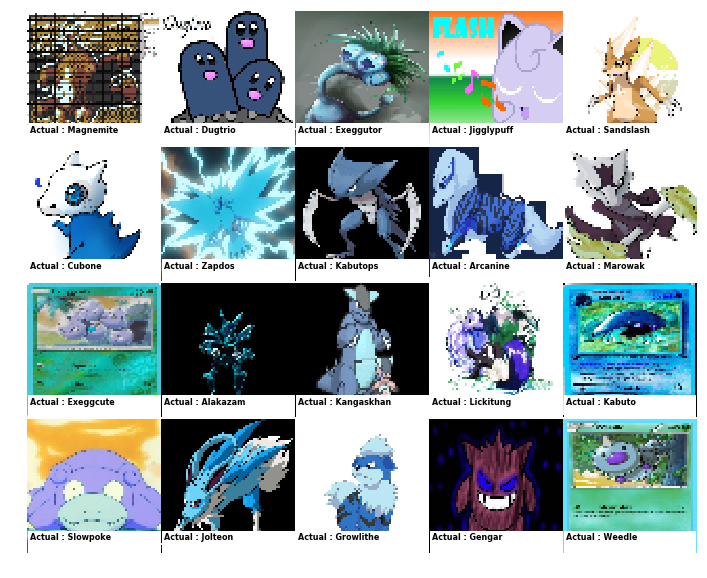

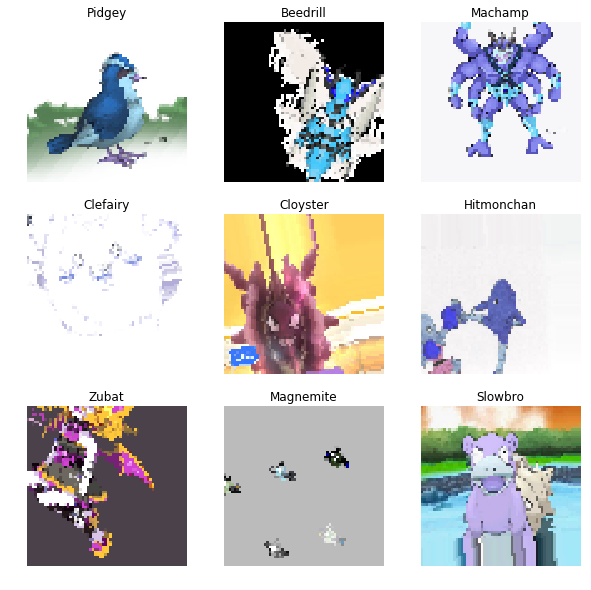

In [29]:
for X_batch, y_batch in data_aug.flow(X_train, y_train, batch_size=9):
    # create a grid of 3x3 images
    plt.figure(figsize=(10,10))
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.title(labels_dict[y_batch[i]])
        plt.imshow(X_batch[i].reshape(64, 64, 3))
        plt.axis('off')
    # show the plot
    plt.show()
    break

## Converting a class vector (integers) to a binary class matrix

In [8]:
num_classes = 151
y_train = np_utils.to_categorical(y_train, num_classes).astype('float32')
y_test = np_utils.to_categorical(y_test, num_classes).astype('float32')

    Why relu?
    Nonlinearities and preservation of dimension that help to improve the robustness of the network and control overfitting   

In [11]:
def create_cnn_model():
    cnn_model = Sequential()
    cnn_model.add(Conv2D(32, kernel_size=(3,3), input_shape = (64, 64, 3), activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
    cnn_model.add(MaxPool2D(pool_size=(2,2)))
    cnn_model.add(Dropout(0.25)) # To construct independent activations for neurons in each intermediate weight layer.


    cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                     activation ='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                     activation ='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPool2D(pool_size=(2,2)))
    cnn_model.add(Dropout(0.25))

    cnn_model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', 
                     activation ='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', 
                     activation ='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPool2D(pool_size=(2,2)))
    cnn_model.add(Dropout(0.25))

    cnn_model.add(Flatten())
    cnn_model.add(Dense(1024, activation = "relu"))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(151, activation = "softmax"))
    return cnn_model

In [11]:
cnn_model = create_cnn_model()

In [12]:
cnn_model.compile(optimizer = rmsprop() , loss = "categorical_crossentropy", metrics=["accuracy"])

In [13]:
checkpoint = ModelCheckpoint('model/best_model.hdf5', monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')

# Reduce learning rate when a metric has stopped improving.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, 
                                            verbose=1, min_lr = .00001)

In [14]:
train_generator = cnn_model.fit_generator(data_aug.flow(X_train,y_train, batch_size=32, shuffle=True),
                              epochs = 128, validation_data = (X_test,y_test),
                               steps_per_epoch=X_train.shape[0] // 32
                              , callbacks=[learning_rate_reduction, checkpoint])


Epoch 1/128
1050/1050 [==============================] - 71s - loss: 4.6610 - acc: 0.1023 - val_loss: 3.6112 - val_acc: 0.2251
Epoch 2/128
1050/1050 [==============================] - 69s - loss: 3.6809 - acc: 0.2142 - val_loss: 3.0395 - val_acc: 0.3153
Epoch 3/128
1050/1050 [==============================] - 69s - loss: 3.3034 - acc: 0.2725 - val_loss: 2.9046 - val_acc: 0.3512
Epoch 4/128
1050/1050 [==============================] - 69s - loss: 3.1160 - acc: 0.3133 - val_loss: 2.5152 - val_acc: 0.4281
Epoch 5/128
1050/1050 [==============================] - 69s - loss: 2.9861 - acc: 0.3397 - val_loss: 2.4579 - val_acc: 0.4450
Epoch 6/128
1050/1050 [==============================] - 69s - loss: 2.8946 - acc: 0.3598 - val_loss: 2.5861 - val_acc: 0.4157
Epoch 7/128
1050/1050 [==============================] - 69s - loss: 2.8113 - acc: 0.3774 - val_loss: 2.5718 - val_acc: 0.4311
Epoch 8/128
1050/1050 [==============================] - 69s - loss: 2.7985 - acc: 0.3791 - val_loss: 2.3455 - 

1050/1050 [==============================] - 69s - loss: 2.2453 - acc: 0.4957 - val_loss: 1.8718 - val_acc: 0.5885
Epoch 32/128
1050/1050 [==============================] - 69s - loss: 2.2238 - acc: 0.5024 - val_loss: 2.2221 - val_acc: 0.5537
Epoch 33/128
1050/1050 [==============================] - 69s - loss: 2.2351 - acc: 0.4990 - val_loss: 2.1946 - val_acc: 0.5423
Epoch 34/128
1050/1050 [==============================] - 69s - loss: 2.2232 - acc: 0.5063 - val_loss: 2.3851 - val_acc: 0.5556
Epoch 35/128
1050/1050 [==============================] - 69s - loss: 2.2082 - acc: 0.5053 - val_loss: 2.1700 - val_acc: 0.5645
Epoch 36/128
1050/1050 [==============================] - 69s - loss: 2.2142 - acc: 0.5053 - val_loss: 2.4581 - val_acc: 0.5497
Epoch 37/128
1049/1050 [============================>.] - ETA: 0s - loss: 2.1983 - acc: 0.5080
Epoch 00036: reducing learning rate to 0.00020000000949949026.
Epoch 00036: val_acc did not improve
1050/1050 [==============================] - 69s -

1050/1050 [==============================] - 69s - loss: 1.7650 - acc: 0.6116 - val_loss: 1.7897 - val_acc: 0.6682
Epoch 63/128
1050/1050 [==============================] - 69s - loss: 1.7499 - acc: 0.6135 - val_loss: 1.8229 - val_acc: 0.6641
Epoch 64/128
1050/1050 [==============================] - 69s - loss: 1.7609 - acc: 0.6103 - val_loss: 1.7400 - val_acc: 0.6695
Epoch 65/128
1050/1050 [==============================] - 69s - loss: 1.7560 - acc: 0.6110 - val_loss: 1.7726 - val_acc: 0.6690
Epoch 66/128
1049/1050 [============================>.] - ETA: 0s - loss: 1.7530 - acc: 0.6110
Epoch 00065: reducing learning rate to 1e-05.
Epoch 00065: val_acc did not improve
1050/1050 [==============================] - 69s - loss: 1.7532 - acc: 0.6111 - val_loss: 1.7822 - val_acc: 0.6689
Epoch 67/128
1050/1050 [==============================] - 69s - loss: 1.7440 - acc: 0.6163 - val_loss: 1.7799 - val_acc: 0.6669
Epoch 68/128
1050/1050 [==============================] - 69s - loss: 1.7393 - a

1050/1050 [==============================] - 69s - loss: 1.7234 - acc: 0.6178 - val_loss: 1.7704 - val_acc: 0.6698


In [208]:
fig, ax = plt.subplots(2,1)
ax[0].plot(train_generator.history['loss'], color='b', label="Training loss")
ax[0].plot(train_generator.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(train_generator.history['acc'], color='b', label="Training accuracy")
ax[1].plot(train_generator.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [15]:
def load_trained_model(weights_path):
    cnn_model = create_cnn_model()
    cnn_model.load_weights('model/best_model.hdf5')

In [9]:
from keras.models import load_model
cnn_model = load_model('model/best_model.hdf5')








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
pred_prob = cnn_model.predict(X_test)
pred_classes = np.argmax(pred_prob, axis=1)
acc = (np.argmax(y_test,axis=1) == pred_classes).mean()

print("Accuracy %.2f %%"% (acc*100))


Accuracy 73.08 %


Normalized confusion matrix
[[0.58333333 0.02777778 0.25       ... 0.         0.         0.        ]
 [0.         0.9020979  0.00699301 ... 0.         0.         0.        ]
 [0.00657895 0.         0.875      ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.76470588 0.         0.        ]
 [0.         0.         0.         ... 0.         0.78181818 0.        ]
 [0.         0.         0.02631579 ... 0.         0.         0.63157895]]


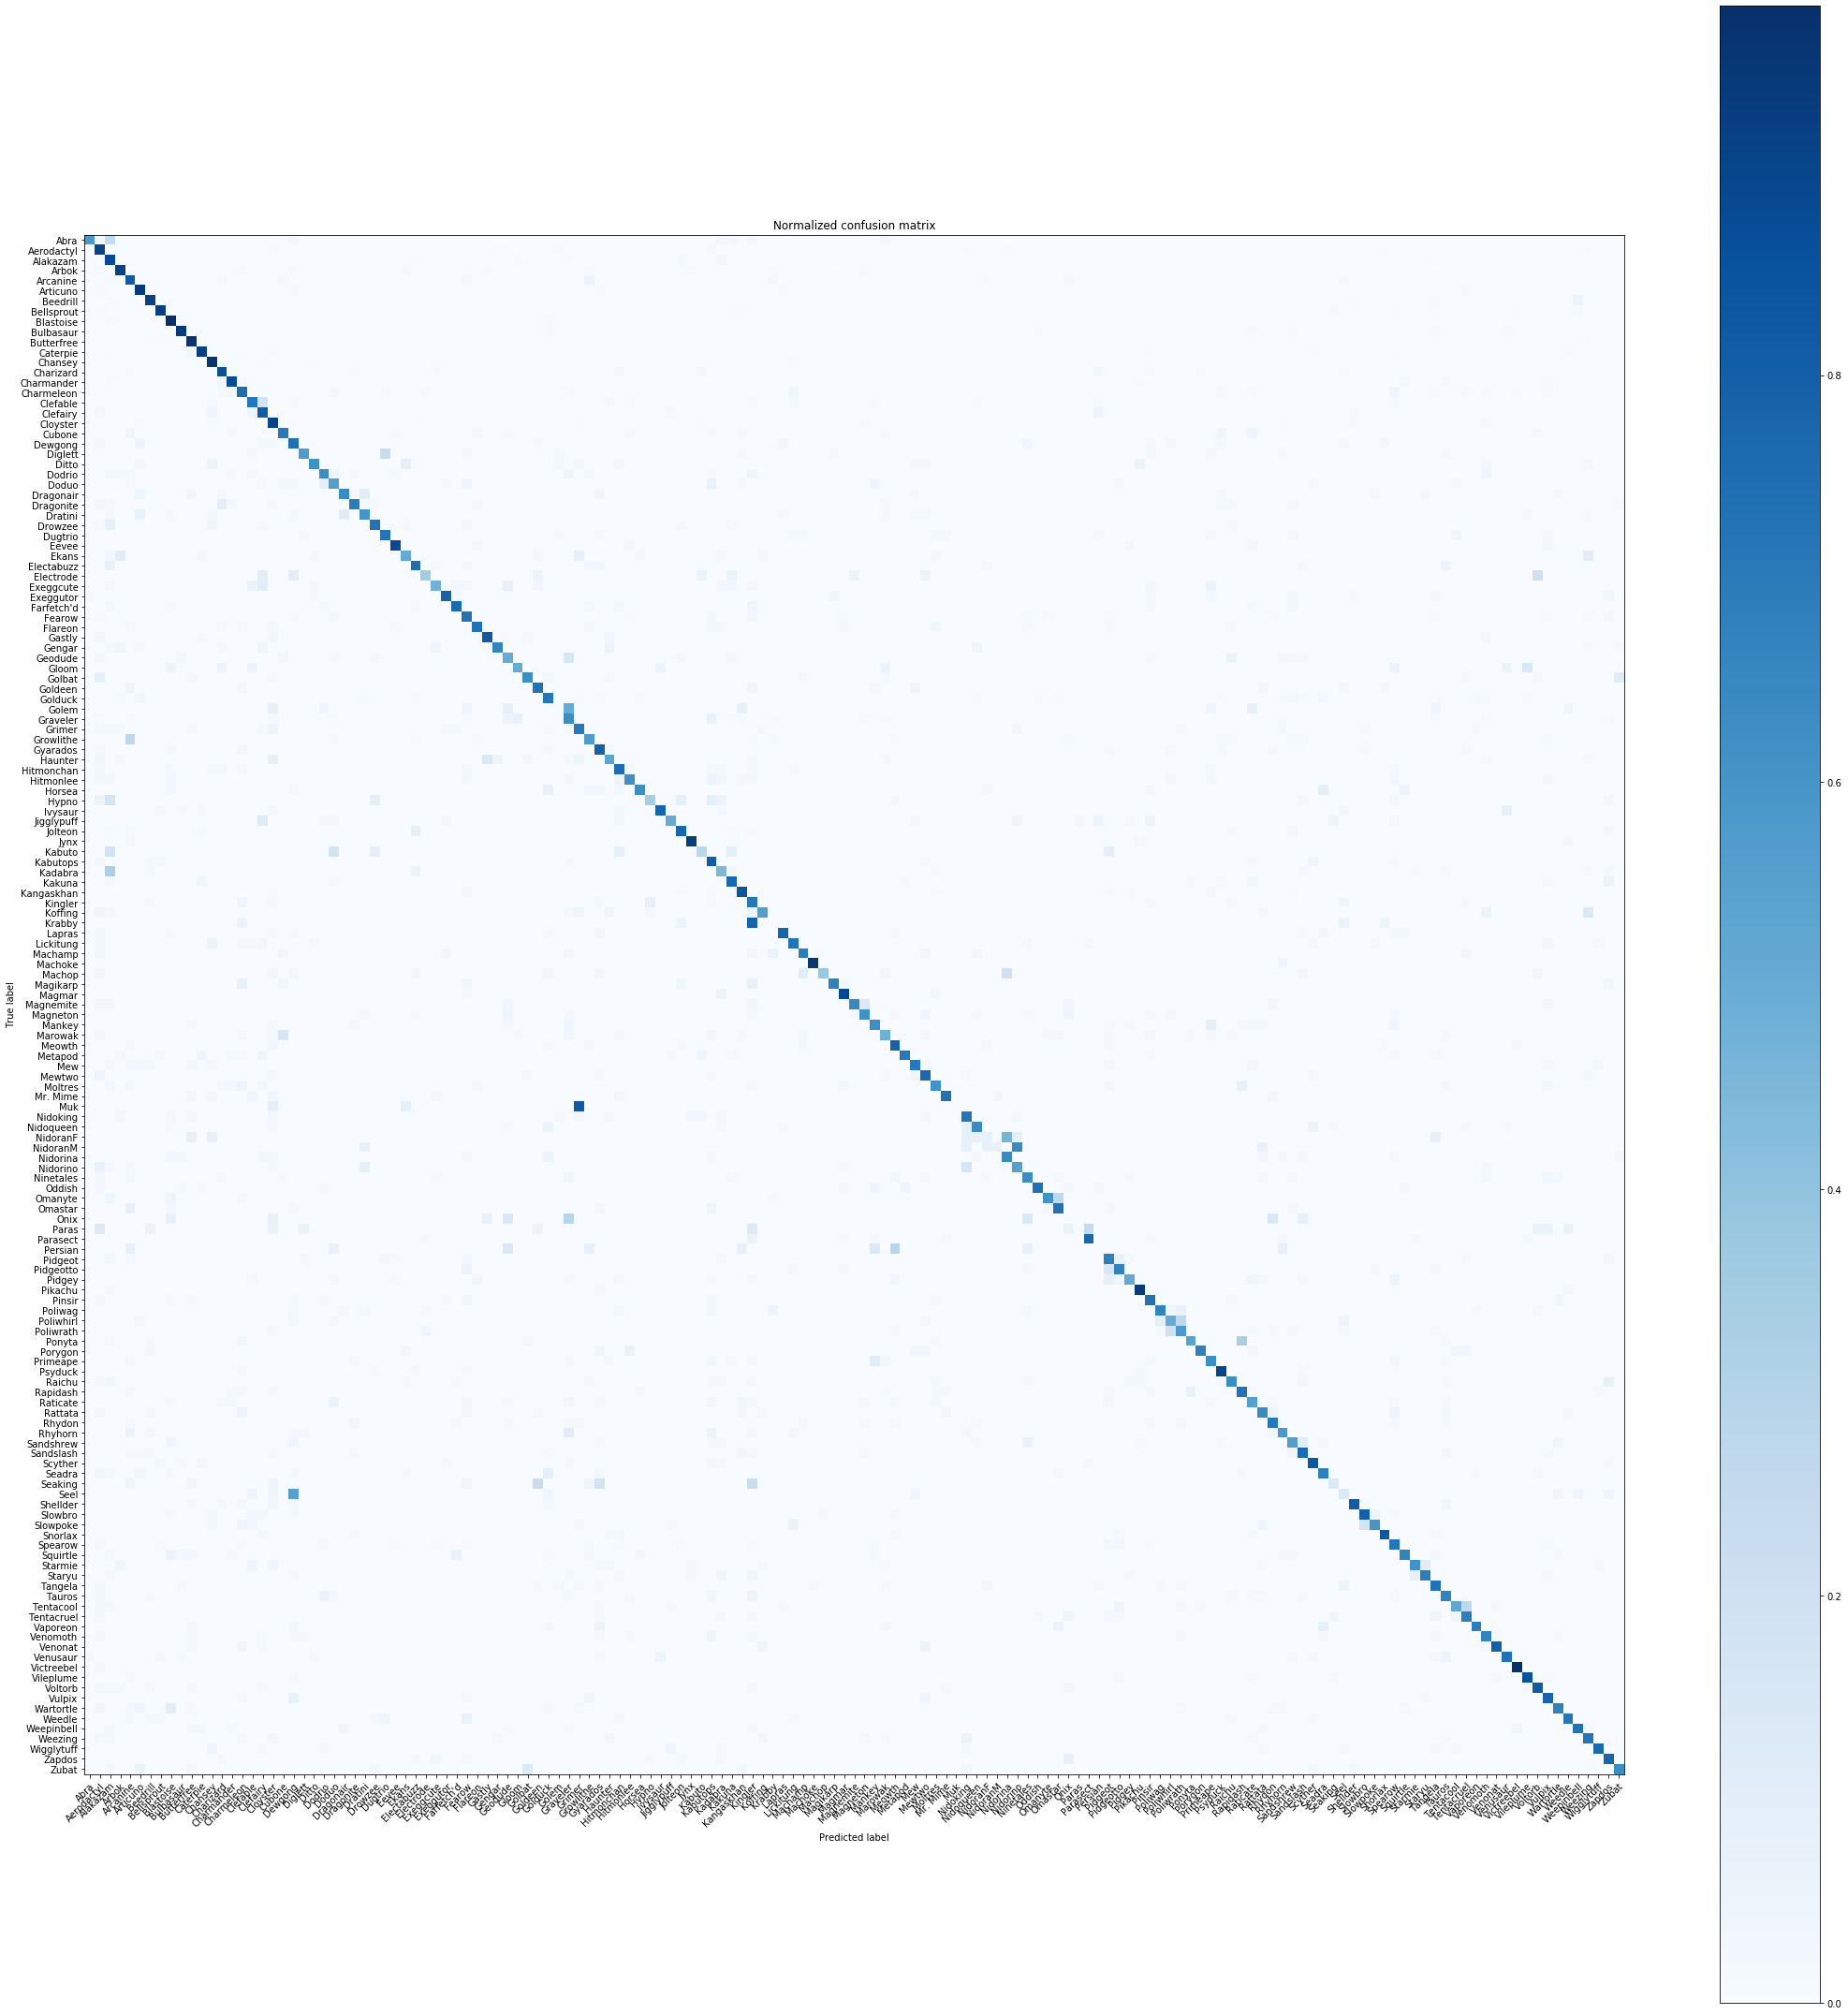

In [44]:
cnn_cm = confusion_matrix(np.argmax(y_test,axis=1),pred_classes)
plot_confusion_matrix(cnn_cm, labels_dict, normalize=True)

In [154]:
df_cnn_cm = pd.DataFrame(data=cnn_cm, index=labels_dict.values(), columns=labels_dict.values())
normalized_cnn_cm = df_cnn_cm.div(df_cnn_cm.sum(axis=1))
diag = np.diag(normalized_cnn_cm)
not_classified = np.where(diag.flatten() == 0)[0]
pokemon_not_classified = [labels_dict[n] for n in a]
print(pokemon_not_classified)

['Golem', 'Krabby', 'Muk', 'Onix', 'Paras', 'Persian']


In [192]:
def get_false_negatives(df,pokemon):
    """
    input - df (confusion matrix dataframe)
    pokemon has to be in not classified list
    ['Golem', 'Krabby', 'Muk', 'Onix', 'Paras', 'Persian']
    Takes pokemon name and returns to its false negatives in order of rate
    
    """
    fn = df.loc[pokemon][df.loc[pokemon] > 0].sort_values(ascending=False)
    return(fn.index.values.tolist())

for pokemon in pokemon_not_classified:
    print(pokemon, get_false_negatives(normalized_cnn_cm,pokemon))
    print('--------------------------------------------------------------------------')

Golem ['Graveler', 'Geodude', 'Raticate', 'Kangaskhan', 'Weedle', 'Dodrio', 'Primeape', 'Tangela', 'Fearow', 'Cloyster']
--------------------------------------------------------------------------
Krabby ['Kingler', 'Seel', 'Snorlax', 'Jolteon', 'Charmeleon']
--------------------------------------------------------------------------
Muk ['Grimer', 'Ekans', 'Cloyster']
--------------------------------------------------------------------------
Onix ['Graveler', 'Geodude', 'Rhydon', 'Ninetales', 'Gastly', 'Sandslash', 'Blastoise', 'Cloyster']
--------------------------------------------------------------------------
Paras ['Parasect', 'Onix', 'Kingler', 'Goldeen', 'Weedle', 'Vulpix', 'Diglett', 'Voltorb', 'Aerodactyl', 'Beedrill', 'Cloyster']
--------------------------------------------------------------------------
Persian ['Meowth', 'Geodude', 'Mankey', 'Rhyhorn', 'Doduo', 'Ninetales', 'Kangaskhan', 'Growlithe', 'Arcanine']
----------------------------------------------------------------

In [207]:
report = classification_report(y_test,pred,target_names=list(labels_dict.values()),output_dict = True)
classification_report_df = pd.DataFrame(report).T
classification_report_df.head()

,f1-score,precision,recall,support
Abra,0.700000,0.875000,0.583333,36.0
Aerodactyl,0.767857,0.668394,0.902098,143.0
Alakazam,0.734807,0.633333,0.875000,152.0
Arbok,0.895397,0.877049,0.914530,117.0
Arcanine,0.729927,0.657895,0.819672,122.0


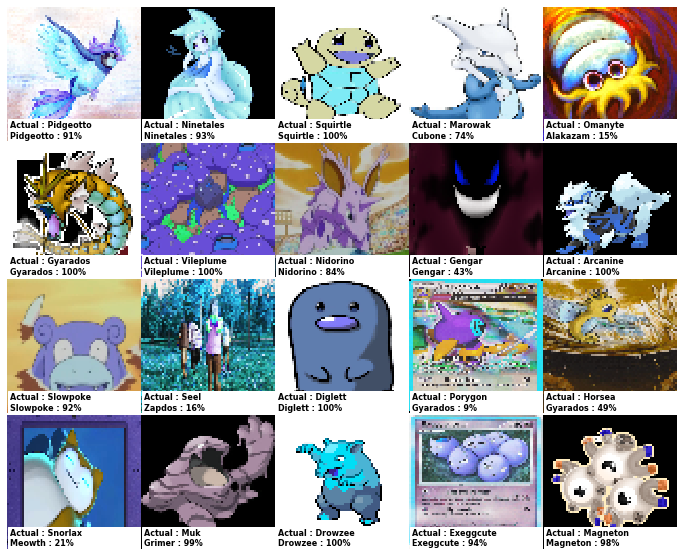

In [228]:
rand_pokemon_keys = random.sample(range(0,151),20)
samples_indices = [random_pokemon_key(key, y_test) for key in rand_pokemon_keys]
display_sample_pokemons(samples_indices, X_test, y_test,pred_classes,pred_prob)

## Video DEMO


In [21]:
def load_icons_pokemons(filenames):
    dict_io = {}
    for file_path in filenames:
        file_path = str(file_path)
        pokemon_icon = cv2.imread(file_path)
        pokemon_icon = cv2.resize(pokemon_icon,(48,48),interpolation=cv2.INTER_LANCZOS4)
        pokemon = file_path.split('/')[-1].split('.png')[0].capitalize()
        dict_io[pokemon] = pokemon_icon
    return dict_io

p = Path("./data/pokemon_icons")
filenames = sorted(p.glob("*.png"))
icons = load_icons_pokemons(filenames)

In [22]:
video_capture = cv2.VideoCapture("./data/video/pokemon_intro.mp4")

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
fps = int(video_capture.get(cv2.CAP_PROP_FPS))
height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
out = cv2.VideoWriter('./data/video/output.mp4', fourcc, 20, (width,height))

In [ ]:
while video_capture.isOpened():
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    frame_for_pred = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    
    frame_reshaped = cv2.resize(frame_for_pred,(64,64),interpolation=cv2.INTER_LANCZOS4)/255.0
    frame_reshaped_array = image.img_to_array(frame_reshaped)
    Y_pred = cnn_model.predict(np.array([frame_reshaped_array]))
    
    index_sorted = np.argsort(Y_pred,axis= 1)[0]
    
    top1_pred = Y_pred[0][index_sorted][-1]
    top2_pred = Y_pred[0][index_sorted][-2]
    top3_pred = Y_pred[0][index_sorted][-3]
    
    # I only display confident predictions (>=70%) 
    if top1_pred > .3:
        pokemon_top1 = labels_dict[index_sorted[-1]]
        pokemon_top2 = labels_dict[index_sorted[-2]]
        pokemon_top3 = labels_dict[index_sorted[-3]]

        Text1 = "%s : %.2f%%"%(pokemon_top1.split('_')[0],top1_pred*100)
        Text2 = "%s : %.2f%%"%(pokemon_top2.split('_')[0],top2_pred*100)
        Text3 = "%s : %.2f%%"%(pokemon_top3.split('_')[0],top3_pred*100)

        frame[2:50,2:50] = icons[pokemon_top1]
        cv2.putText(frame,Text1,(2,65), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

        frame[80:128,2:50] = icons[pokemon_top2]
        cv2.putText(frame,Text2,(2,143), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

        frame[158:206,2:50] = icons[pokemon_top3]
        cv2.putText(frame,Text3,(2,221), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

        # Display the resulting frame
        cv2.imshow('Video', frame)

        out.write(frame)

        cv2.waitKey(0)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
# When everything is done, release the capture
video_capture.release()
out.release()
cv2.destroyAllWindows()